In [2]:
%load_ext autoreload
%autoreload all

import torch

from gem import DFC2022Dataset, DFC2022DataModule

dir_path = '/GEM/data/MiniFrance/'
datamodule = DFC2022DataModule(dir_path, img_size=2048, patch_size=512, batch_size=6, num_workers=6)

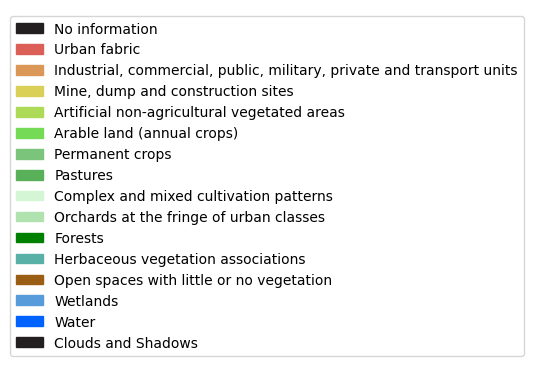

In [3]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

handles = [Patch(color=c, label=l) for l, c in zip(DFC2022Dataset.classes, DFC2022Dataset.colormap)]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.show()

In [4]:
import lightning as pl
import os

from gem import EarthMapping

os.chdir('/GEM')
MAX_EPOCHS = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = datamodule.dataset.calc_class_weights().to(device)
model = EarthMapping(class_weights=class_weights)

if device.type == 'cuda':
    trainer = pl.Trainer(enable_progress_bar=True, accelerator='gpu', devices=1, max_epochs=MAX_EPOCHS)
else:
    trainer = pl.Trainer(enable_progress_bar=True, accelerator='cpu', max_epochs=MAX_EPOCHS)

trainer.fit(model, datamodule)

KeyboardInterrupt: 

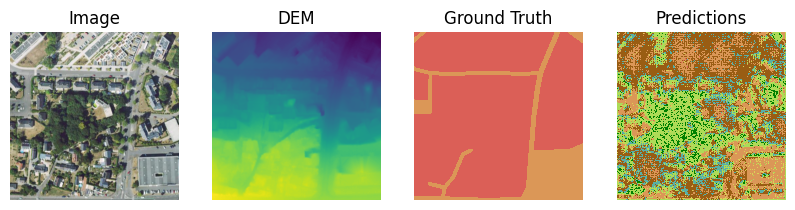

In [ ]:
import torch

datamodule.setup()
batch = next(iter(datamodule.val_dataloader()))
cmap = mcolors.ListedColormap(DFC2022Dataset.colormap)

model.eval()
with torch.no_grad():
    preds = model(batch)
    batch['image'] *= 255
    batch['prediction'] = preds.argmax(dim=1)
    batch['prediction'] = torch.tensor(cmap(batch['prediction']))
    batch['mask'] = batch['mask'].squeeze(0)
    batch['mask'] = torch.tensor(cmap(batch['mask']))
    samples = [dict(zip(batch, t)) for t in zip(*batch.values())]

    for sample in samples:
        datamodule.dataset.plot(sample)